# <font color=#B2D732> <span style="background-color: #4424D6">  Brain and spinal cord fMRI denoising </font>

@ author of the script:  <font color=#B2D732> Caroline Landelle </font>, caroline.landelle@mcgill.ca // landelle.caroline@gmail.com   
@ Contribution and adjustements: <font color=#B2D732>  Nawal Kinany </font>, nawal.kinany@epfl.ch  

**Description:** This notebook provides code for BOLD signal fMRI resting-state denoising, template registration and smoothing  
see Landelle et al. 2023:   
*For each individual, we accounted for the physiological and other noise sources by modeling nuisance noises present in CSF and by collecting physiological data using the Tapas PhysiO toolbox (Kasper et al., 2017). First, we used the RETROspective Image CORrection (RETROICOR) procedure (Glover et al., 2000) [..] Second, [...] we used the CompCor (Behzadi et al., 2007) approach [...]. Finally, we applied a bandpass filter 0.01-0.17 Hz to emphasize low-frequency signals of interest.*

> <font color=#B2D732> **I.** </font> **Denoising: Retroicor + Compcor**  
> <font color=#B2D732> **II.** </font> **DCT calculation**  
> <font color=#B2D732> **III.** </font> **Signal cleaning**  
> <font color=#B2D732> **IV.** </font> **Normalization to template**  
> <font color=#B2D732> **V.** </font> **Smoothing**  
> <font color=#B2D732> **VI.** </font> **Concatenation: Brain + Spinal cord image**  
   
**Toolbox required:** Tapas PhysiO Toolbox (SPM, Matlab) , nilearn (Python), FSL (bash)  
https://github.com/translationalneuromodeling/tapas/tree/master/PhysIO  
https://www.sciencedirect.com/science/article/pii/S016502701630259X  

**Inputs**:  
This notebook required this the following prepross anatomical, fmri images and physiological recoridings


**Ouputs**:
See the output description at each step of the Notebook.

## <font color=#B2D732> <span style="background-color: #4424D6"> Initialization </font>  
Before running the script you should create a config.json file with the right pathways

In [54]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Main imports ------------------------------------------------------------
import sys,json, glob, os, shutil
import matlab.engine
import nibabel as nb
import numpy as np
import scipy.stats as stats
import pandas as pd

# homemade functions -------------------------------------------------------------
code_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project/"
os.chdir(code_dir)
sys.path.append(code_dir + "/code/") # Change this line according to your directory

from brsc_denoising import Denoising
import brsc_utils as utils
from brsc_preprocess import Preprocess_Sc, Preprocess_Br,Preprocess_BrSc

# Load config file ------------------------------------------------------------
with open(code_dir + '/config/preprocessing/02_brsc_denoising.json') as config_file: # the notebook should be in 'xx/notebook/' folder #config_proprio
    config = json.load(config_file) # load config file should be open first and the path inside modified
with open(code_dir + '/config/preprocessing/01_brsc_preprocess_func.json') as config_file: # the notebook should be in 'xx/notebook/' folder #config_proprio
    config_preproc = json.load(config_file) # load config file should be open first and the path inside modified

denoising=Denoising(config)

preprocess_Sc=Preprocess_Sc(config_preproc)
preprocess_Br=Preprocess_Br(config_preproc)
preprocess_BrSc=Preprocess_BrSc(config_preproc)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/denoising/slice_wise/1_func_denoised/sub-A006_test/
The config files should be manually modified first
All the raw data should be store in BIDS format
 


## <font color=#B2D732> <span style="background-color: #4424D6"> I. Outliers calculation based on DVARS </font> 
> Volumes in which scan-to-scan displacement exceeded 1 mm were then detected and included as noise regressors during the denoising step   
> Calculate DVARS [FSL, fsl_motion_outliers] 

In [55]:
### maybe recalcultate them slice wise :)
outliers={}
for structure in config["structures"]:
    outliers[structure]=[]
    for ID in config["participants_IDs"]:
        outliers[structure].append(denoising.outliers(ID=ID,structure=structure,redo=False))


        

/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing//sub-A006_test//func/3_MOCO/brain/*moco.nii.gz
/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing//sub-A006_test//func/3_MOCO/spinalcord/*moco.nii.gz


## <font color=#B2D732> <span style="background-color: #4424D6"> II. File preparation </font> </span> 
> <font color=#B2D732> 1. </font>  **Unzip data for SPM**    
> <font color=#B2D732> 2. </font>  **Create denoising directories  & copy.tsv files**     
> <font color=#B2D732> 3. </font>  **Create slice wise motion parameter .tsv file**     


### <font color=#4424D6> II.1 Unzip SPM data </font>

In [56]:
csf_infunc_files={}
for structure in config["structures"]:
    csf_infunc_files[structure]=[]
    for ID in config["participants_IDs"]:
        for run_nb,run in enumerate(config["design_exp"]["ses_names"]):
            main_dir=config["preproc_dir_bmpd"] if ID[0]=="P" else config["preproc_dir"]
            csf_infunc_file=glob.glob(main_dir + config["seg_files"][structure]["csf_infunc"].format(ID,run))[0]
            csf_infunc_files[structure].append(utils.unzip_file(csf_infunc_file,ext='.nii',redo=False,verbose=False)) # do not redo for spinalcord before corrected manually the CSF mask 

### <font color=#4424D6> II.2 Create denoising directories  & copy.tsv files </font>
Copy and unzippe physio files. Note that the physio files should be in .tsv (BIDS) or log format before running that script

In [57]:
physio_files=[]
for ID in config["participants_IDs"]:
    for run_nb,run in enumerate(config["design_exp"]["ses_names"]):
        physio_files.append(denoising.find_physio_file(ID=ID,
                                                       run_name=run,
                                            copy=True, # if you want to copy the data somewhere else than the rawdata directory
                                            output_dir=config["denoising"]["dir"].format(ID,run), #  needed if copy=True 
                                            redo=False))

### <font color=#4424D6> II.3 Create slice wise motion parameter .tsv file  </font>

In [58]:
for structure in config["structures"]:
    for ID in config["participants_IDs"]:
        for run_nb,run in enumerate(config["design_exp"]["ses_names"]):
            denoising.moco_params(ID=ID, run_name=run,structure=structure,redo=False)
     

Brain moco params were already extracted please, put redo=True to recalculate it
Spinal cord moco params were already extracted please, put redo=True to recalculate it


/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project//code/brsc_denoising.py:300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  moco_brain=pd.read_csv(input_file, delim_whitespace=True, header=None) # load motion parameter file


## <font color=#B2D732> <span style="background-color: #4424D6"> III. Run Retroicor </font> </span> 
*We used the RETROspective Image CORrection (RETROICOR) procedure (Glover et al., 2000) to generate noise regressors from peripheral physiological recordings. This method models the respiratory and cardiac phases for each functional volume. A low-order Fourier expansion was then calculated to model the physiological noise. We modeled six cardiac and eight respiratory harmonics and four multiplicative terms for the interactions between cardiac and respiratory noise, as well as one regressor for heart rate variability and one for the respiratory volume per time.  
NEW !! The outputs are generated slice wise*

/!\ If there is a beug like "No peaks found in raw cardiac time series. Check raw physiological recordings figure whether there is any non-constantcardiac data" it is possible that you have NaN in your physio file.

<span style="background-color: #FFFACD"> <font color=#efb017> /!\ </font>  **Check point:**  physiological recording graph:  *sub-XX_Physio.png* </span> 

In [59]:
os.chdir(code_dir +'/code/spm/')# need to change the directory to find the toolbox
eng = matlab.engine.start_matlab()

for structure in config["structures"]:
    physio_mat={}
    for run_nb, run_name in enumerate(config["design_exp"]["ses_names"]):
        physio_mat[run_name]=[]
        for ID_nb, ID in enumerate(config["participants_IDs"]):
            preproc_dir=config["preproc_dir_bmpd"] if ID[0]=="P" else config["preproc_dir"]
            #A. Run TAPAS_________________________________________
            PhysioDir=config["denoising"]["dir"].format(ID,run_name) +structure +'/confounds/' # output directory

            nb_slices = nb.load(glob.glob(preproc_dir + config["moco_files"]["dir"].format(ID,run_name,structure) + config["moco_files"]["moco_mean_f"])[0]).shape[2] # extract number of slices
           
            if len(physio_files[ID_nb])==2:
                resp_file=physio_files[ID_nb][0];cardio_file=physio_files[ID_nb][1];
            else:
                resp_file=physio_files[ID_nb];cardio_file=physio_files[ID_nb];
            
            utils.unzip_file(glob.glob(preproc_dir + config["moco_files"]["dir"].format(ID,run_name,structure) + config["moco_files"]["moco_f"])[0],
                             ext='_SPM.nii',redo=False) #unzip moco if it was not already done
            
            tapas_outfile_name='_18_retroicor_' +structure
            
        
            if not os.path.exists(PhysioDir +  'sub-'+ ID +  tapas_outfile_name +'_slice001.txt'):
                print(eng.TapasPhysiO(ID, # sub_name
                                      preproc_dir + config["moco_files"]["dir"].format(ID,run_name,structure), # inputDir : Moco directory
                                      os.path.basename(glob.glob(preproc_dir + config["moco_files"]["dir"].format(ID,run_name,structure) + config["moco_files"]["moco_f"])[0]).split('.')[0] + '_SPM.nii', #func_img : Moco file unzipped
                                      config["acq_params"]["TR"], # TR ,
                                      config["acq_params"]["physio_frq"][0],
                                      config["acq_params"]["physio_json"],# set to 1 in you have json file related to physio files
                                      nb_slices, #nb_slices: number of slices
                                      "",#csf_infunc_files[structure][ID_nb], #csf_mask : unzipped CSF in func image
                                      cardio_file ,
                                      resp_file , 
                                      "", # no timing is privided
                                      tapas_outfile_name, #outfile_name name of the outputfile
                                      PhysioDir,# outputDir
                                      config)) # config file
                print('for ' + ID  + ' ' +structure )
                print('**************************************************')
            else:
                print('Tapas already done for ' + ID + ' '   + structure )
                print('**************************************************')

            for slice_nb in range(1,nb_slices):
                slice_str="00" + str(slice_nb + 1) if (slice_nb+1)<10 else "0" + str(slice_nb+1)
                mat_file=PhysioDir +  'sub-'+ ID +  tapas_outfile_name +'_slice'+slice_str+'.mat'
                if os.path.exists(mat_file):
                    os.remove(mat_file) # remove all mat files exept for the first slice as they are havy
            
            denoising.plot_physio(glob.glob(PhysioDir+'*retroicor*.mat')[0],
                             PhysioDir,
                              ID=ID,
                              save=True) # to plot and save physio put save=True
   

Tapas already done for A006_test brain
**************************************************
Tapas already done for A006_test spinalcord
**************************************************


## <font color=#B2D732> <span style="background-color: #4424D6"> III. CompCor and DCT calculation </font> </span> 
1. Discrete cosine transform (DCT) expresses a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies.  The DCT is similar to the discrete Fourier transform: it transforms a signal from the spatial domain to the frequency domain. DCT improve the denoising, we found a significant improvement for iCAPS analyses
2. Second, to eliminate the non-neural aspects of the signal, we used the CompCor (Behzadi et al., 2007) approach by extracting the mean signal and the first five principal components of the unsmoothed signal recorded from the CSF (CSF-mask in functional space).

In [60]:
DCT_files={}; compcor_files={};
for structure in config["structures"]:
    compcor_files[structure]=[];DCT_files[structure]=[]
    print(structure)
    for run_nb,run in enumerate(config["design_exp"]["ses_names"]):
        for ID_nb, ID in enumerate(config["participants_IDs"]):
            print(ID)
            preproc_dir=config["preproc_dir_bmpd"] if ID[0]=="P" else config["preproc_dir"]
            #print(main_dir + config["seg_files"][structure]["dir_func"].format(ID) + config["seg_files"][structure]["seg_func"])
            compcor_comp,DCT_comp=denoising.confounds_ts(ID=ID,
                                                         run_name=run,
                                                         func_file=glob.glob(preproc_dir + config["moco_files"]["dir"].format(ID,run,structure) + config["moco_files"]["moco_f"])[0],
                                                         mask_csf_file=csf_infunc_files[structure][ID_nb],
                                                         mask_seg_file=glob.glob(preproc_dir + config["seg_files"][structure]["seg_func"].format(ID,run))[0],
                                                         n_compcor=5 if structure=="spinalcord" else 12,
                                                         structure=structure,
                                                         compcor=True,
                                                         DCT=True,
                                                         redo=False)
            compcor_files[structure].append(compcor_comp)
            DCT_files[structure].append(DCT_comp)



brain
A006_test
spinalcord
A006_test


## <font color=#B2D732> <span style="background-color: #4424D6"> IV. Clean functional data </font> </span> 
### <font color=#4424D6> IV.1 Grouped confounds for brain and spinal cord separatly</font>
<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  **Check point** the denoising matrices  </span> 

brain
A006_test
spinalcord
A006_test


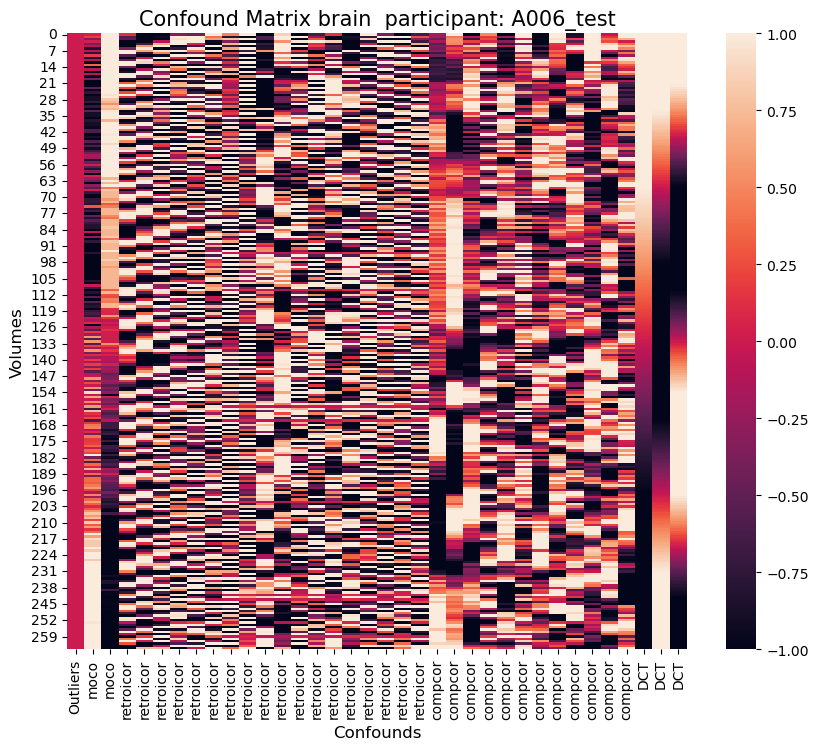

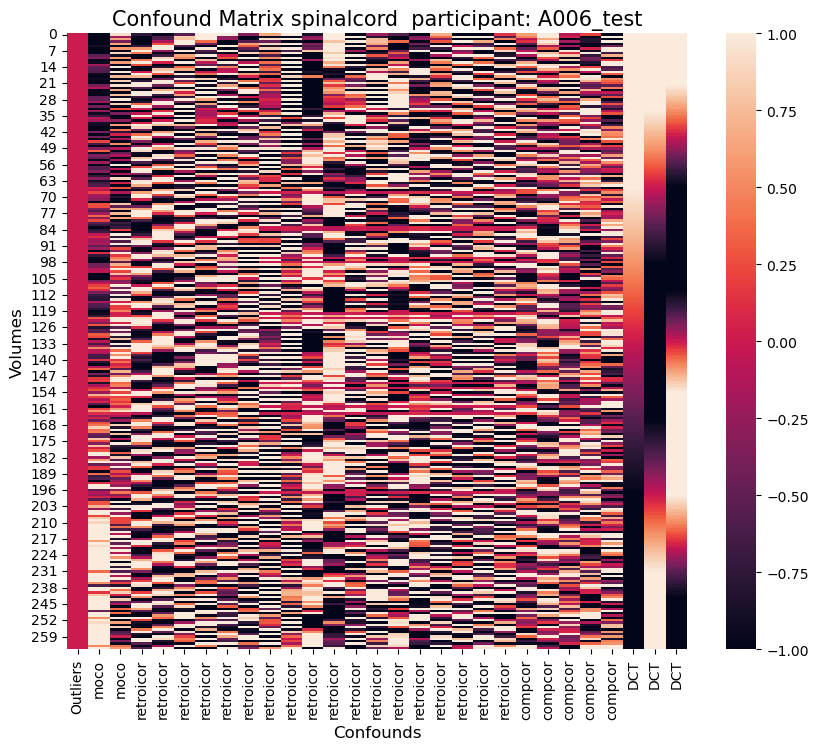

In [61]:
confounds={}
confound_infos={};Counfounds_allsbj={}
for structure in config["structures"]:
    confounds[structure]=[]
    print(structure)
    for run_nb,run in enumerate(config["design_exp"]["ses_names"]):
        for ID_nb, ID in enumerate(config["participants_IDs"]):
            print(ID)
    
            confound_infos['brain']={'Outliers':1,'moco':2,'retroicor':18,'compcor':12,'DCT':3}
            confound_infos['spinalcord']={'Outliers':1,'moco':2,'retroicor':18,'compcor':5,'DCT':3}
            confounds[structure].append(denoising.combine_confounds(ID=ID,
                                                                    run_name=run,
                                                                        confounds_infos=confound_infos[structure],
                                                                        structure=structure,
                                                                        retroicor_confounds=True,
                                                                        compcor_confounds=True,
                                                                        moco_confounds=True,
                                                                        outliers_confounds=outliers[structure][ID_nb],
                                                                        DCT_confounds=True,
                                                                        slice_wise=True,
                                                                        redo=False))
                
            denoising.plot_confound_design(ID=ID,
                                               confound_file=confounds[structure][ID_nb][1].split("_slice")[0] + "_slice020_z.txt",
                                               confounds_infos=confound_infos[structure],
                                               structure=structure,
                    save=True)


## <font color=#B2D732> <span style="background-color: #4424D6"> IV. Image Cleaning </font> 
> Here we are going to remove the confounds that we extracted and merge below.  
> The denoising will be run for each slice  
>  If you want to filter the data you should apply a BP: [0.01-0.017] Hz or HP filtering only before running icaps.  
    
According to Lindquist et al. (2018), removal of confounds will be done orthogonally to temporal filters (low- and/or high-pass filters), if bothare specified.

*note to myself:*  
Brain:  0 outliers + 6  motion param + 18 retroicor + 12 compcor + 3 DCT + [0.01] hz or [0.01-0.017] hz  
Spinal cord:  0 outliers + 2  motion param + 18 retroicor + 5 compcor + 3 DCT + [0.01] hz or [0.01-0.017] hz  
       
<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  **Check point** check denoised images  </span> 

In [62]:
Clean_image_file={};Clean_meanimage_file={};
filtering_params = {
    "BP": {"high_pass": 0.01, "low_pass": 0.17},
    "HP": {"high_pass": 0.01, "low_pass": None},
    "nofilter": {"high_pass": None, "low_pass": None}}


for structure in config["structures"]:
    print(structure)
    Clean_image_file[structure]={}; Clean_meanimage_file[structure]={}
    for filtering in ["nofilter"]:#,"BP","nofilter","HP"]:
        Clean_image_file[structure][filtering]=[]
        for run_nb,run in enumerate(config["design_exp"]["ses_names"]):
            for ID_nb, ID in enumerate(config["participants_IDs"]):
                print(ID)
                preproc_dir=config["preproc_dir_bmpd"] if ID[0]=="P" else config["preproc_dir"]
                Clean_image_file[structure][filtering].append(denoising.clean_images(
                    ID=ID,
                    run_name=run,
                    confounds_file=confounds[structure][ID_nb][0],
                    mask_file=glob.glob(preproc_dir + config["seg_files"][structure]["seg_func"].format(ID,run))[0],
                    #mask_file=glob.glob(preproc_dir + config["seg_files"][structure]["seg_func"].format(ID,run).split(".")[0] + "_dilated.nii.gz")[0],
                    structure=structure,
                    high_pass=filtering_params[filtering]["high_pass"],
                    low_pass= filtering_params[filtering]["low_pass"], 
                    tag_name=filtering + "_nostd" , #std means the data were z-scored
                    standardize=False,#"zscore", # False if you don't want
                    n_jobs=4,redo=False))
                          
                


brain
A006_test
spinalcord
A006_test


## <font color=#B2D732> <span style="background-color: #4424D6"> V. Normalization to template </font>  
The denoised data are normalise in template space (Using spline).
For brain images we should first coregister to the anat. Then from anat space to MNI
For sc images the warping field already include the func_T1w transformation and anat to PAM50 transformation

<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  **Check point** normalised images  </span> 

In [ ]:
Norm_Clean_file={};Coreg_Clean_file={}
for structure in config["structures"]:
    if structure =="spinalcord":
        #os.system('find /tmp /var/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;')
        #os.system('find /tmp /var/tmp /export02/data/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;')
        warp_f=[];Norm_Clean_file[structure]={};o_folders=[];dest_img=[]
        for filtering in ["nofilter"]:#,"BP","HP"]:
            for run_nb,run in enumerate(config["design_exp"]["ses_names"]):
                for ID_nb, ID in enumerate(config["participants_IDs"]):
                    print(ID)
                    preproc_dir=config["preproc_dir_bmpd"] if ID[0]=="P" else config["preproc_dir"]
                    warp_f.append(glob.glob(preproc_dir + config["normalization"]["spinalcord"]["warp_f"].format(ID,run))[0])
                    o_folders.append(config["normalization"]["dir"].format(ID,run_name)+ structure + "/")
                    dest_img.append(config["tools_dir"]["main_codes"] + "/template/"+ config["PAM50_t2_cropped"])
               
                #Norm_Clean_file[structure][filtering]=
                Norm_Clean_file[structure][filtering]=preprocess_Sc.apply_warp(
                        i_img=Clean_image_file[structure][filtering], # input clean image
                        ID=config["participants_IDs"],
                        o_folder=o_folders, # output folder
                        dest_img=dest_img, # PAM50 template
                        warping_field=warp_f,
                        tag="_inTemplate",
                        mean=True,
                        n_jobs=4,redo=False)
    
    elif structure=="brain":
        Coreg_Clean_file[structure]={}; Norm_Clean_file[structure]={}
        for filtering in ["nofilter"]:#,"BP","HP"]:
            Coreg_Clean_file[structure][filtering]=[]; Norm_Clean_file[structure][filtering]=[]
            warp_f=[]
            #1. run coregistration between the func and anat image
            
            for ID_nb, ID in enumerate(config["participants_IDs"]):
                
                # coregister mean image into T1w image
                preproc_dir=config["preproc_dir_bmpd"] if ID[0]=="P" else config["preproc_dir"]
                warp_f.append(glob.glob(config["preproc_dir"] + config["normalization"][structure]["warp_f"].format(ID,run))[0])
    
                # coregister mean image into T1w image
                Coreg_Clean_file[structure][filtering].append(preprocess_Br.coregistration_func2anat(ID=ID,
                                                                     func_img=glob.glob(preproc_dir + config["moco_files"]["dir"].format(ID,run,structure) + config["moco_files"]["moco_mean_f"])[0],
                                                                     anat_img=glob.glob(preproc_dir+ config["normalization"]["brain"]["T1w_native"].format(ID))[0],
                                                                     filenames_func4D=Clean_image_file[structure][filtering][ID_nb],
                                                                     o_folder=config["normalization"]["dir"].format(ID) + "/brain/",
                                                                     tag="_inT1w",redo=False,verbose=False))
                
                #2. run normalization between the func and MNI space using dartel template
                print(config["tools_dir"]["main_codes"] + "/template/"+ config["MNI_mask"])
                print(Coreg_Clean_file[structure][filtering][ID_nb][1])
                Norm_Clean_file[structure][filtering].append(preprocess_Br.dartel_norm(ID=ID,
                                                      dartel_template=glob.glob(config["normalization"]["brain"]["dartel_dir"].format(config["normalization"]["brain"]["dartet_tag"]))[0],
                                                      warp_file=glob.glob(warp_f[ID_nb])[0],
                                                      i_file=glob.glob(Coreg_Clean_file[structure][filtering][ID_nb][1])[0],
                                                      o_file=Coreg_Clean_file[structure][filtering][ID_nb][1].split(".")[0] + "_inTemplate.nii",
                                                       brain_mask=config["tools_dir"]["main_codes"] + "/template/"+ config["MNI_mask"],
                                                     redo=False))

                print(Norm_Clean_file[structure][filtering])          

Brain functional coregistration into anat space was already done, set redo=True to run again the coregistration
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project//template//MNI152_T1_1mm_brain_mask_2mm.nii.gz
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/denoising/slice_wise/2_func_in_template/sub-A006_test//brain/sub-A006_test_task-rest_bold_stc_brain_moco_nofilter_nostd_inT1w.nii


------------------------------------------------------------------------
07-Oct-2025 13:15:44 - Running job #1
------------------------------------------------------------------------
07-Oct-2025 13:15:44 - Running 'Normalise to MNI Space'

** "y_sub-A006_test_T1w_brain" **
sub-A006_test_task-rest_bold_stc_brain_moco_nofilter_nostd_inT1w	1,1,1	2,1,1	3,1,1	4,1,1	5,1,1	6,1,1	7,1,1	8,1,1	9,1,1	10,1,1	11,1,1	12,1,1	13,1,1	14,1,1	15,1,1	16,1,1	17,1,1	18,1,1	19,1,1	20,1,1	21,1,1	22,1,1	23,1,1	24,1,1	25,1,1	26,1,1	27,1,1	28,1,1	29,1,1	30,1,1	31,1,1	32,1,1	33,1,1	34,1,1	35

In [ ]:
#redo 31
std_Clean_file={}
mask=[]
for structure in ["spinalcord"]:
    std_Clean_file[structure]=[]
    for ID_nb, ID in enumerate(config["participants_IDs"]):
        std_Clean_file[structure].append(Norm_Clean_file[structure][filtering][ID_nb].split("HP_")[0]+filtering +"_std_inTemplate.nii.gz")

        if structure =="brain":
            mask.append(config["tools_dir"]["main_codes"] + "/template/"+ config["MNI_mask"])
        elif structure=="spinalcord":
            mask.append(config["tools_dir"]["main_codes"] + "/template/"+ config["PAM50_cord_cropped"])
        
denoising.standardize(input_files=Norm_Clean_file[structure][filtering],output_files=std_Clean_file[structure],redo=True,mask_files=mask)

## <font color=#B2D732> <span style="background-color: #4424D6"> VI. Smoothing </font> 
Smoothing is a regularization of the model that decrease the noise level in images, and reduce the discrepancy between individuals. 
We use two differents smoothing for brain and spinal cord, full-width at half maximum (FWHM).  
> Brain: 6x6x6 mm isotropic  
> Spinalcord: 3x3x6 mm anisotropic  

<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  **Check point** smoothed images  </span> 

In [ ]:
#double cjeck
Smoothed_Clean_file={}
if structure =="brain":
    fwhm=[6,6,6] if structure =="brain" else [3,3,6]
    o_folders=[];Smoothed_Clean_file[structure]=[]
    for ID_nb, ID in enumerate(config["participants_IDs"]):
        o_folders.append(config["smoothing"]["dir"].format(ID)+ structure + "/")

    
    Smoothed_Clean_file[structure]=preprocess_BrSc.smooth_img(i_img=Norm_Clean_file[structure][filtering],
                                                              o_folder=o_folders,
                                                                     ID=config["participants_IDs"],
                                                                     fwhm=fwhm,n_jobs=8,redo=True)

    

## <font color=#B2D732> <span style="background-color: #4424D6"> VI. Standardize </font>
the standardization is needed for the icaps analysis

In [ ]:
#redo 31
std_Clean_file={}
mask=[]
for structure in ["spinalcord"]:
    std_Clean_file[structure]=[]
    for ID_nb, ID in enumerate(config["participants_IDs"]):
        std_Clean_file[structure].append(Smoothed_Clean_file[structure][ID_nb].split(".nii.gz")[0]+"_std.nii.gz")

        if structure =="brain":
            mask.append(config["tools_dir"]["main_codes"] + "/template/"+ config["MNI_mask"])
        elif structure=="spinalcord":
            mask.append(config["tools_dir"]["main_codes"] + "/template/"+ config["PAM50_cord_cropped"])
        
denoising.standardize(input_files=Smoothed_Clean_file[structure],output_files=Smoothed_Clean_file[structure],redo=True,mask_files=mask)

New warped image was generated for A006_test


In [ ]:

### Re